<a href="https://colab.research.google.com/github/Salvadorglezf/Classic-deep-learning-exercises/blob/main/Multilayer_perceptron_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tarea 1 Red neuronal Perceptrón multicapa  en Tensorflow 2

#Gonzalez Flores Jesus Salvador

Se implemento el mismo clasificador de prendas de ropa usando el conjunto de datos MNIST fashion. EL objetivo de esta implementación es comparar el proceso entre TF1 y TF2.


In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
from tensorflow.keras.datasets.fashion_mnist import load_data
fashion_mnist = load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
(x_train, y_train), (x_test, y_test)=fashion_mnist

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
imagendemo=x_train[0,:,:]

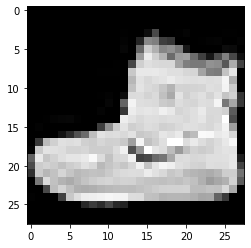

In [7]:
plt.imshow(imagendemo,cmap='gray')

In [8]:
# Define classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [9]:
x_train = x_train.reshape(-1,28*28).astype('float32')
x_test = x_test.reshape(-1,28*28).astype('float32')


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 784)

#Codificación one hot

Se hace uso de la función one hot encoder de scikit kearn para codificar las etiquetas de los datos.

In [10]:
# onehot encode

#En TF2 tampoco tenemos las funciones para codificar en One hot las etiquetas de
#los datos. Por eso, usamos las funciones de SKLearn que importamos 
#Cargamos la función en onehot_encoder
onehot_encoder = OneHotEncoder(sparse=False)
#Le damos forma a nuestro y_train
#La forma es (numero de datos, etiqueta categorica)
y_train = y_train.reshape(len(y_train), 1)
#Las cambiamos a un vector one-hot
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

(60000, 10)

# Definición de la arquitectura

TF2 nos permite manejar como objetos la arquitectura de la red. Dentro de la definición de la arquitectura se decisión una red con 200 nodos y tan solo 2 capas ocultas. Los pesos de cada capa fueron regularizados multiplicados directamente por 0.1 para evitar que los valores numéricos sean demasiado grandes, si se usaban valores más grandes el modelo no superaba una precisión del 80%. Se mantuvo la función de activación Relu y el optimizador ADAM con un learning rate de 0.001 para las métricas de precisión se uso una precisión simple y para la función de perdida se mantuvo la función softmax cross entripy with logits y se usó una métrica de promedios.

In [11]:
#Aqui notamos el primer cambio entre TF1 y TF2.
#En TF1 usabamos una función para declarar la arquitectura de nuestra DNN, pero 
#en TF2 necesitamos hacer un objeto (cambiamos de paradigma estructurado a paradigma orientado a objetos)

class DNN_model(object):
  #Este es el inicializador del objeto, cuando decalaramos un objeto de la clase DNN_model
  #adquiere todo aquello dentro del __init__
  def __init__(self,
               n_nodes_hl1=200,
               n_nodes_hl2=200,
               n_nodes_hl3=200,
               n_nodes_hl4=200,
               n_classes=10):
    #Cada capa de la red, sus pesos y bias, se vuelven un atributo del objeto
    #Ya no tenemos los diccionario de las capas
    #Todos los parametros siguen siendo tf.Variable
    #En TF2 tampoco tenemos los generadores de números aleatorios, por eso, necesitamos
    #utilizar los aleatorios de numpy.
    #Además de eso, tenemos que agregarle un nombre a cada parte de la capa "hl1weigths", "hl1bias", etc
    #También, le agregamos el tipo de dato a cada capa. En TF2 el más adecuado es el float32
    self.h1LW = tf.Variable(0.1*np.random.rand(784, n_nodes_hl1),name="hl1weigths",dtype="float32")
    self.h1LB = tf.Variable(0.1*np.random.rand(n_nodes_hl1),name="hl1bias",dtype="float32")
    self.h2LW = tf.Variable(0.1*np.random.rand(n_nodes_hl1, n_nodes_hl2),name="hl2weigths",dtype="float32")
    self.h2LB = tf.Variable(0.1*np.random.rand(n_nodes_hl2),name="hl2bias",dtype="float32")
    self.h3LW = tf.Variable(0.1*np.random.rand(n_nodes_hl2, n_nodes_hl3),name="hl3weigths",dtype="float32")
    self.h3LB = tf.Variable(0.1*np.random.rand(n_nodes_hl3),name="hl3bias",dtype="float32")
    self.h4LW = tf.Variable(0.1*np.random.rand(n_nodes_hl3, n_nodes_hl4),name="hl4weigths",dtype="float32")
    self.h4LB = tf.Variable(0.1*np.random.rand(n_nodes_hl4),name="hl4bias",dtype="float32")
    self.outW = tf.Variable(0.1*np.random.rand(n_nodes_hl4, n_classes),name="outweigths",dtype="float32")
    self.outB = tf.Variable(0.1*np.random.rand(n_classes),name="outbias",dtype="float32")

    #Finalmente, además de la decalaración de los pesos y bias de las capas, tenemos que inidcar qué atributos del objeto
    #son entrenables. 
    #Esto permite declarar partes que sí se entrenan y partes que no. Esto sucede porque TF2 esta un poco en más bajo nivel
    #que TF1. Estos son los elementos que ajustara el optimizador
    self.trainable_variables =[self.h1LW,self.h1LB,self.h2LW,self.h2LB,self.h3LW,self.h3LB,self.h4LW ,self.h4LB,self.outW,self.outB]          
  
  def __call__(self,x): 
      # Declarando la arquitectura

      #Cuando se genera un objeto, podemos mandar a llamar sus operaciones
      #Para nuestra DNN lo que queremos es hacer es la propagación hacia adelante

      #Las operaciones siguen siendo las de TF1, hacemos X*W+B
      l1 = tf.add(tf.matmul(x,self.h1LW), self.h1LB)
      #aplicamos la función de activación/transferencia
      l1 = tf.nn.relu(l1)

      l2 = tf.add(tf.matmul(l1,self.h2LW), self.h2LB)
      l2 = tf.nn.relu(l2)

      l3 = tf.add(tf.matmul(l2,self.h3LW), self.h3LB)
      l3 = tf.nn.relu(l3)   

      l4 = tf.add(tf.matmul(l3,self.h4LW), self.h4LB)
      l4 = tf.nn.relu(l4)   

      output = tf.matmul(l4,self.outW) + self.outB
      return output
      #Cada vez que mandemos a llamar a la red se ejecuta la propagación hacia adelante

      #TF2 nos permite separar entre el modelo y las funciones propias del entrenamiento
      #como el cálculo del costo y la optimización de parámetros
  

In [12]:
#Hacemos un objeto de la clase DNN_model
DNN = DNN_model()
#Mandamos a llamar la propagación hacia adelante del objeto DNN
#Nuestro objeto es una especie de función, cuando lo mandamos a llamar se ejecuta el "predict"


In [13]:
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)


In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#Aqui esta la exactitud
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [15]:
#Declaramos el paso de entrenamiento

def train_step(model,tdata, labels):
  #Esta funcion recibe el modelo, los datos de entrenamiento y sus etiquetas
  with tf.GradientTape() as tape:
    #Cargamos el calculo de gradiente de tensorflow y lo renombramos como tape (la cinta del gradiente)
    #Todo lo que esta dentro de este encabezado se va a ocupar para el calculo del gradiente
    #Hacemos la propagacion hacia delante de los datos de entrenamiento
    predictions = model(tdata)
    #calculo de una funcion de error 
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
    #Aqui estamos usando la funcion de error que usamos en la red vanilla de TF1 y le indicamos
    #que se calcula con la diferencia entre la prediccion y la etiqueta

  #Ahora, declaramos las operaciones de optimización con nuestra cinta
  #Este paso era oscuro en TF1, en TF2 se vuelve transparente 

  #Se calcula el gradiente como una funcion de la cinta, usando el error y los parametros entrenables del error
  #Aqui le decimos qué se deriva y con respecto a qué, es decir, la perdida con respecto a los pesos y bias
  gradients = tape.gradient(loss, model.trainable_variables)
  #Esto nos da una versatilidad para calcular diferentes gradientes y derivarlos con respecto a datos especificos

  #Ahora, necesitamos ordenar la información antes de pasarla por el optimizador
  #Necesitamos hacer una lista con tuplas: (gradiente, variable) - > [(gradW1, W1),...,(gradWn, Wn)]
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  #Ya con los gradientes y variables ordenados, ejecutamos el optimizador que elegimos
  #optimizador.apply_gradients(zip(gradients,model.trainable_variables))
  optimizador.apply_gradients(capped_grads_and_vars)
  #Se ajustaron los pesos y bias
  #Aqui mandamos a llamar las metricas que declaramos
  #Estas funciones de error y accuracy nos sirven para desplegar el error acumulado
  #y la exactitud de la epoca
  train_loss(loss)
  train_accuracy(labels, predictions)

In [16]:
 #Este cabezal indica que el codigo es compilado, no interpetado
#Esta es la funcion de prueba, para propagar sin modificar los datos
def test_step(model,tdata, labels):
  predictions = model(tdata)
  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [17]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))


# Definición función de entrenamiento

In [18]:
_#En esta funcion hacemos el entrenamiento de la DNN
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
  #Cargamos, el modelo, los datos de entrenamiento y prueba, el número de épocas
  #el numero de lotes a usar y el tamaño de éstos (N_batch*batch_size) == len(dataset)

   #Hacemos el ciclo de épocas
  for epoch in range(EPOCHS):
    i=0

    while i+batch_size < len(train_x):
    #  #Aqui ya no tenemos las funciones para separar los dataset por lotes
    #  #Necesitamos separar los lotes a mano
      start = i
      end = i+batch_size
    #  #Hacemos las rebanadas del tamaño del lote a usar
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
    #Ejecutamos el paso de entrenamiento
      train_step(model,batch_x,batch_y)
      i+=batch_size
     
    test_step(model,test_x,test_y)
    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
    
    #Al finalizar la epoca, reiniciamos los errores y exactitudes para que no se acumulen con el anterior
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

  #En TF2 ya no usamos el diccionario de la red, el cual era uno de los puntos
  #que mayor confusion generaban
    

Para entrenar el modelo se determinaron 18 épocas, 600 lotes con 100 muestras cada uno. Se noto que la precisión es dependiente del tamaño de lotes, pero si los lotes son demasiado grandes el entrenamiento tarda mas tiempo. Entonces se usaron lotes pequeños y un numero de épocas reducido.

# Entrenamiento

In [19]:
fitting(DNN,x_train,y_train_onehot,x_test,y_test_onehot,18,600,100) #EPOCHS,N_batch,batch_size

Epoch 1, Perdida: 115.8009033203125, Exactitud: 11.238731384277344, Perdida de prueba: 2.473464250564575, Exactitud de prueba: 10.380000114440918
Epoch 2, Perdida: 2.3757667541503906, Exactitud: 15.634390830993652, Perdida de prueba: 2.2096025943756104, Exactitud de prueba: 17.43000030517578
Epoch 3, Perdida: 2.050739049911499, Exactitud: 26.12854766845703, Perdida de prueba: 1.6955230236053467, Exactitud de prueba: 35.88999938964844
Epoch 4, Perdida: 1.3807839155197144, Exactitud: 48.87145233154297, Perdida de prueba: 1.1190603971481323, Exactitud de prueba: 57.400001525878906
Epoch 5, Perdida: 0.9887275695800781, Exactitud: 64.07678985595703, Perdida de prueba: 0.8863478302955627, Exactitud de prueba: 69.8499984741211
Epoch 6, Perdida: 0.8004429340362549, Exactitud: 71.78797912597656, Perdida de prueba: 0.7425963878631592, Exactitud de prueba: 75.08000183105469
Epoch 7, Perdida: 0.6781839728355408, Exactitud: 76.22036743164062, Perdida de prueba: 0.6625884771347046, Exactitud de prue

#Entrenamiento 
Como conclusión, TF2 nos permite manipular los parámetros de nuestros modelos de forma numérica, esto me permitió definir un modelo más preciso y mas rápido de entrenar. Pude confirmar la dependencia de la profundidad de la red y el impacto del número de lotes en el desempeño de la red.